In [1]:
from DatasetTools import BirdsData
import os
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import csv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,average_precision_score,f1_score
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from hyperopt import fmin, tpe, hp,Trials,STATUS_OK,space_eval
from joblib import dump, load
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

<h4>For XGBoost we filter our dataset, such that only most important and useful features for classification are included.</h4>

In [2]:
full_df = BirdsData('bird_data').get_dataframe()
full_df = full_df.sample(frac=1) #shuffle dataset randomly
class_labels = {
    0: 'other',
    1: 'comcuc',
    2: 'cowpig1',
    3: 'eucdov',
    4: 'eueowl1',
    5: 'grswoo',
    6: 'tawowl1'
}
# print(full_df)
#FILTER DATASET. LEAVE JUST MOST IMPORTANT FEATURES
df_filtered = full_df.filter(like='cln_melspect_mean') \
                .join(full_df.filter(like='cln_contrast_mean')) \
                .join(full_df.filter(like='cln_mfcc_mean'))\
                .join(full_df.filter(like='cln_power_mean'))\
                .join(full_df.filter(like='cln_energy_mean')) \
                .join(full_df.filter(like='cln_centroid_mean'))\
                .join(full_df.filter(like='cln_flatness_mean')) \
                .join(full_df.filter(like='cln_melspect_std'))\
                .join(full_df.filter(like='cln_mfcc_std')) \
                .join(full_df.filter(like='raw_contrast_mean'))\
                .join(full_df.filter(like='raw_melspect_mean')) \
                .join(full_df.filter(like='raw_mfcc_mean'))\
                .join(full_df.filter(like='raw_flux_std')) \
                .join(full_df.filter(like='raw_melspect_std'))\
                .join(full_df.filter(like='raw_mfcc_std')) \
                .join(full_df.filter(like='raw_power_std'))\
                .join(full_df.filter(like='raw_energy_std')) \
                .join(full_df.filter(like='yin'))\
                .join(full_df['target'])   
full_df = df_filtered

#FOR XHG BOOST. CHANGE OUR TARGET FROM NAMES TO NUMBERS
for i,class_name in enumerate(class_labels.values()):
    full_df['target'] = full_df['target'].replace(str(class_name), i)

#DELETE TARGET COLUMN FROM OUR DATASET. GET ONLY LABELS COLUMN. WILL BE USED FOR CLASSIFICATION
labels = full_df['target']
del full_df['target']

def get_full_df():
    full_df = BirdsData('bird_data').get_dataframe()
    class_labels = {
        0: 'other',
        1: 'comcuc',
        2: 'cowpig1',
        3: 'eucdov',
        4: 'eueowl1',
        5: 'grswoo',
        6: 'tawowl1'
    }
    for i,class_name in enumerate(class_labels.values()):
        full_df['target'] = full_df['target'].replace(str(class_name), i)
    labels = full_df['target']
    del full_df['target']
    return full_df,labels

<h4>For SVM we need full dataset. Run this cell below if you are running SVM</h4>

In [2]:
full_df = BirdsData('bird_data').get_dataframe()
class_labels = {
    0: 'other',
    1: 'comcuc',
    2: 'cowpig1',
    3: 'eucdov',
    4: 'eueowl1',
    5: 'grswoo',
    6: 'tawowl1'
}
for i,class_name in enumerate(class_labels.values()):
    full_df['target'] = full_df['target'].replace(str(class_name), i)
labels = full_df['target']
del full_df['target']


For classification , it is a common technique to write class labels as integers, not as stings.
We separate target column from our main dataset

<h1>Train multiple classifiers and determine the best among them</h1>

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(full_df, labels, test_size = 0.4, random_state = 0)

def model_assess(model,x_train,y_train,x_test,y_test, title = "Default"):
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

params = {
            'objective':'binary:logistic',
            'max_depth': 10,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':1000,
            'tree_method':'gpu_hist'
        } 
# Cross Gradient Booster
xgb = xgb.XGBClassifier(**params)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = xgb.XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

<h4>Here we blindly perform classification using different classification algorithms (without tuning hyperparameters.) 
Accuracy Naive Bayes : 0.73772 

Accuracy Stochastic Gradient Descent : 0.86964 

Accuracy KNN : 0.90031 

Accuracy Decission trees : 0.83972 

Accuracy Random Forest : 0.87967 

Accuracy Support Vector Machine : 0.89378 

Accuracy Logistic Regression : 0.87636 

Accuracy Neural Nets : 0.873 

Accuracy Cross Gradient Booster : 0.92042

<b>As we see, XGBoost performed better than the other algorithms.So we will try to train XGBoost model, with hyperparameter tuning. In addition, we will train SVM model, as it is suitable for large datasets</b>
</h4>

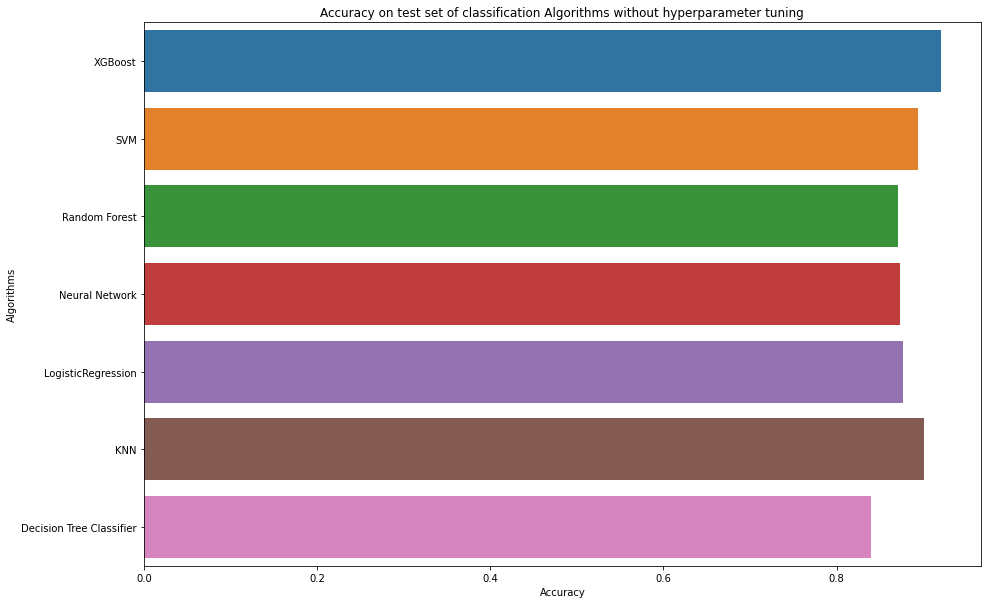

In [8]:
def plot_model_acc(accuracy,names):
    data={'classifier':np.array(names),'accuracy': np.array(accuracy)}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['accuracy'], ascending=False,inplace=True)
    plt.figure(figsize=(15,10))
    sns.barplot(x=fi_df['classifier'], y=fi_df['accuracy'])
    plt.title('Accuracy on test set of classification Algorithms without hyperparameter tuning')
    plt.xlabel('Accuracy')
    plt.ylabel('Algorithms')

algorithms = ["KNN","Decision Tree Classifier","Random Forest",'SVM',"LogisticRegression",'Neural Network','XGBoost']
performance = [0.90031,0.83972,0.87067,0.89378,0.87636,0.873,0.92042]

plot_model_acc(algorithms,performance)

<h2>Training XGBoost model</h2>

In [13]:
def plot_cv(scores,title="CV scores plot",x_title="Fold number",y_title='Accuracy'):
    folds = [i+1 for i in range(len(scores))]
    print(folds)
    plt.figure(figsize=(10,8))
    plt.bar(folds,scores)
    plt.xticks(folds)
    plt.title(title)
    plt.ylim(top=1)
    plt.xlabel(x_title)
    plt.ylabel(y_title)


<h4>We want to find best hyperparameters for our model. Below we define different values for each parameter. A our objective function we decided to use multi:softmax, as we have 7 different class labels.
In order to speed-up the process of hyperparametrising (as is usually takes really long), we split our dataset twice.
<br/>
    'objective':'multi:softmax'<br/>
    'learning_rate': [0.0001, 0.01, 0.1, 1]<br/>
    'max_depth' : range(3,10,2)<br/>
    'gamma' : [i/10.0 for i in range(0,5)]<br/>
    'colsample_bytree' :i/10.0 for i in range(3,10)<br/>
    'reg_alpha' : [1e-5, 0.1, 1, 10]<br/>
    'reg_lambda' : 1e-5, 0.1, 1, 10]<br/>
    'num_class':7,<br/>
    'n_estimators':[400,700,1000,1300]<br/>
</h4>

In [ ]:
X_train, X_hyp, y_train, y_hyp = train_test_split(full_df, labels, test_size = 0.5, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_hyp, y_hyp, test_size = 0.7, random_state = 0)


In [ ]:


space = {
    'objective':hp.choice('objective',['multi:softmax']),
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,10,2)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 0.1, 1, 10]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 0.1, 1, 10]),
    'num_class':7,
    'n_estimators':hp.choice('n_estimators', [400,700,1000,1300]),
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def objective(params):
    xgboost = xgb.XGBClassifier(seed=0,predictor='gpu_predictor',tree_method='gpu_hist', **params)
    xgboost.fit(X_train, y_train)
    score = f1_score(y_test, xgboost.predict(X_test), average='micro')
    loss = - score
    print(loss)
    return {'loss': loss, 'params': params,'status':STATUS_OK}

best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = Trials())
best_params = space_eval(space, best)
print('Best_Params:',best_params)


<h4>We now get which model hyperparameters are the best for our model.</h4>

#Best_Params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700, 'num_class': 7, 'objective': 'multi:softmax', 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}

Now peform Cross validation and see how our parameters perform

In [ ]:
#Best_Params: {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700, 'num_class': 7, 'objective': 'multi:softmax', 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}


scores = []
VER = 1
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=0)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            full_df, labels )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)

    X_train = full_df.loc[train_idx]
    y_train = labels.loc[train_idx]
    X_valid = full_df.loc[valid_idx]
    y_valid = labels.loc[valid_idx]
    
    # dtrain = xgb.DMatrix(data=X_train, label=y_train)
    # dvalid = xgb.DMatrix(data=X_valid, label=y_valid)

    xgb_model_opt = xgb.XGBClassifier(seed=0, 
                            colsample_bytree=space_eval(space, best)['colsample_bytree'], 
                            objective=space_eval(space, best)['objective'],
                            gamma=space_eval(space, best)['gamma'], 
                            learning_rate=space_eval(space, best)['learning_rate'], 
                            max_depth=space_eval(space, best)['max_depth'], 
                            reg_alpha=space_eval(space, best)['reg_alpha'],
                            reg_lambda=space_eval(space, best)['reg_lambda'],
                            n_estimators=space_eval(space, best)['n_estimators'],
                            tree_method='gpu_hist',
                            predictor='gpu_predictor',
                            nthread=6,
                            num_class=7
                            )


    xgb_model_opt.fit(X_train, y_train,eval_set=[(X_valid, y_valid)],verbose=2)
    y_pred = xgb_model_opt.predict(X_valid)
    scores.append(accuracy_score(y_pred, y_valid))
    xgb_model_opt.save_model(f'XGB_optimal_fold{fold}.xgb')
    
    del X_train,y_train
    del X_valid, y_valid
print(scores)

<h5>
Results on cross-validation with 5 splits. <br/>
On average, model with parameters {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700, 'num_class': 7, 'objective': 'multi:softmax', 'reg_alpha': 1e-05, 'reg_lambda': 1e-05} performed with such accuracies: </br>
<br/>
Accuracy on cross validation: <br/>
[0.9372083333333333, 0.9375416666666667, 0.9375833333333333, 0.9380833333333334, 0.9390416666666667]<br/>
Which is quite well.
</h5>

[1, 2, 3, 4, 5]


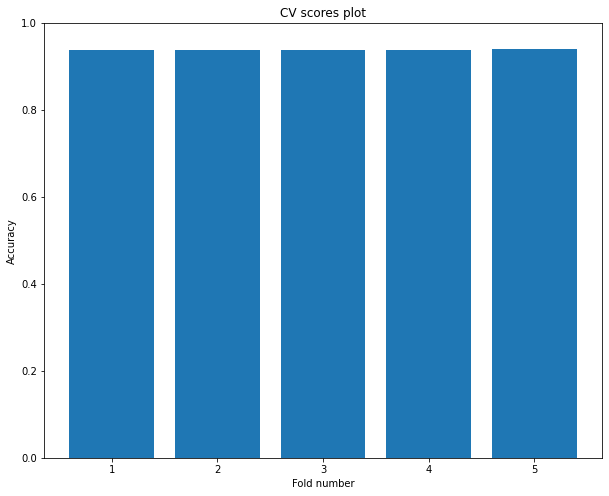

In [14]:
xgboost_crosval = [0.9372083333333333, 0.9375416666666667, 0.9375833333333333, 0.9380833333333334, 0.9390416666666667]
plot_cv(xgboost_crosval)


Now we train our model with these parameters on the whole dataset

In [3]:
full_df, labels = get_full_df()
# xgb_model = xgb.XGBClassifier(seed=0, 
#                             colsample_bytree=space_eval(space, best)['colsample_bytree'], 
#                             objective=space_eval(space, best)['objective'],
#                             gamma=space_eval(space, best)['gamma'], 
#                             learning_rate=space_eval(space, best)['learning_rate'], 
#                             max_depth=space_eval(space, best)['max_depth'], 
#                             reg_alpha=space_eval(space, best)['reg_alpha'],
#                             reg_lambda=space_eval(space, best)['reg_lambda'],
#                             n_estimators=space_eval(space, best)['n_estimators'],
#                             tree_method='gpu_hist',
#                             predictor='gpu_predictor',
#                             nthread=6,
#                             num_class=7
#                             )


# {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700, 'num_class': 7, 'objective': 'multi:softmax', 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}

xgb_model = xgb.XGBClassifier(seed=0, 
                            colsample_bytree=0.5, 
                            objective='multi:softmax',
                            gamma=0.0, 
                            learning_rate=0.1, 
                            max_depth=5, 
                            reg_alpha=1e-05,
                            reg_lambda=1e-05,
                            n_estimators=700,
                            tree_method='gpu_hist',
                            predictor='gpu_predictor',
                            nthread=6,
                            num_class=7
                            )

xgb_model.fit(full_df, labels,verbose=2)
y_pred = xgb_model.predict(full_df)
print('-- Model Report --')
print('XGBoost Accuracy: '+ str(accuracy_score(y_pred, labels)))
print('XGBoost F1-Score (Micro): '+str(f1_score(y_pred,labels,average='micro')))
print(classification_report(labels, y_pred))

xgb_model.save_model(f'XGB_final_model_best_params_test.xgb')

-- Model Report --
XGBoost Accuracy: 0.9995333333333334
XGBoost F1-Score (Micro): 0.9995333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85358
           1       1.00      1.00      1.00      5833
           2       1.00      1.00      1.00      8954
           3       1.00      1.00      1.00      8198
           4       1.00      1.00      1.00      2324
           5       1.00      1.00      1.00      5111
           6       1.00      1.00      1.00      4222

    accuracy                           1.00    120000
   macro avg       1.00      1.00      1.00    120000
weighted avg       1.00      1.00      1.00    120000



On this point, accuracy of our trained model is 99%, which is almost perfect. <br/>
We will see then how our model performs on unseen data, when we will get data for final classification<br/>
Our trained model is saved under - 'XGB_final_model_best_params.xgb'
<hr/>


-- Model Report --<br/>
XGBoost Accuracy: 0.9995333333333334<br/>
XGBoost F1-Score (Micro): 0.9995333333333334<br/>
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85358
           1       1.00      1.00      1.00      5833
           2       1.00      1.00      1.00      8954
           3       1.00      1.00      1.00      8198
           4       1.00      1.00      1.00      2324
           5       1.00      1.00      1.00      5111
           6       1.00      1.00      1.00      4222

    accuracy                           1.00    120000
   macro avg       1.00      1.00      1.00    120000
weighted avg       1.00      1.00      1.00    120000


<h1>Train SVM classifier</h1>
First explore which features are most important based on XGBoost results. Then we will leave only most important features on our dataset, and run SVM algorithm on those

In [3]:
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('XGB_final_model_best_params.xgb')

['raw_mfcc_d2_std_0' 'raw_mfcc_std_0' 'cln_melspect_mean_9'
 'raw_contrast_mean_3' 'cln_melspect_mean_5' 'cln_contrast_mean_3'
 'cln_contrast_mean_4' 'raw_melspect_std_6' 'cln_mfcc_mean_0'
 'raw_melspect_std_8' 'cln_mfcc_std_0' 'raw_melspect_mean_7'
 'cln_melspect_mean_7' 'raw_contrast_std_3' 'cln_melspect_mean_4'
 'raw_melspect_mean_6' 'raw_energy_std' 'yin_7' 'raw_melspect_mean_5'
 'raw_mfcc_d_std_0' 'raw_contrast_mean_4' 'raw_mfcc_mean_10'
 'raw_mfcc_mean_12' 'raw_power_std' 'raw_melspect_std_7'
 'cln_contrast_mean_2' 'cln_mfcc_d2_std_0' 'raw_melspect_std_5' 'zcr_mean'
 'raw_melspect_mean_4' 'cln_melspect_mean_6' 'raw_power_mean'
 'raw_mfcc_d_mean_0' 'raw_mfcc_mean_13' 'raw_melspect_std_4'
 'raw_melspect_std_9' 'cln_contrast_mean_5' 'raw_mfcc_mean_16'
 'cln_melspect_mean_10' 'cln_energy_std' 'yin_8' 'cln_mfcc_d_mean_0'
 'raw_melspect_std_3' 'cln_melspect_mean_37' 'raw_flux_std'
 'cln_melspect_std_8' 'raw_mfcc_mean_9' 'raw_melspect_mean_8'
 'cln_melspect_mean_19' 'raw_mfcc_mean_3']


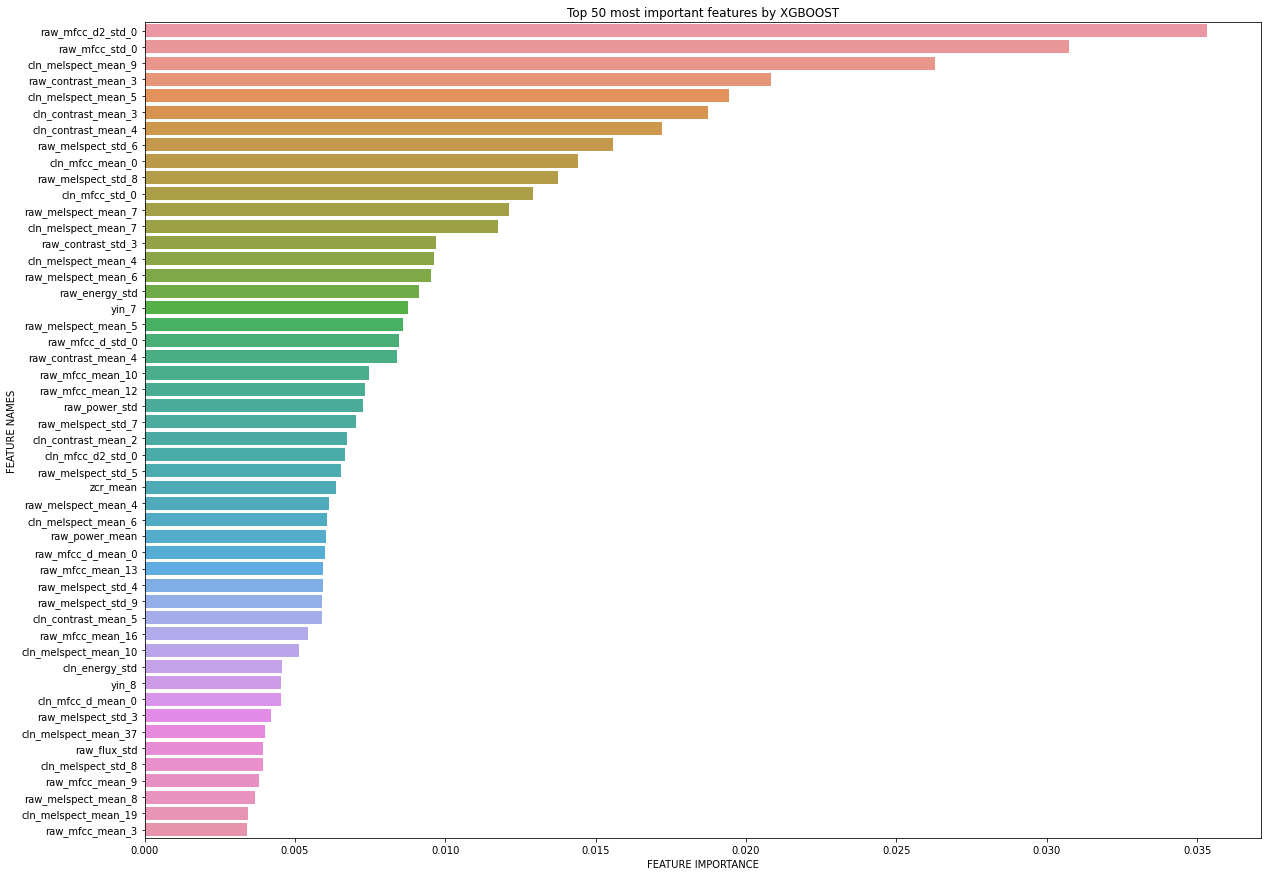

In [4]:
importances = loaded_model.feature_importances_
def plot_feature_importance(importance,names,model_type,topk=50):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:topk]
    top_features = np.array(fi_df.values)[:,0]
    plt.figure(figsize=(20,15))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return top_features
feature_plot = plot_feature_importance(importances,full_df.columns,'Top 50 most important features by XGBOOST')
top_50_features = feature_plot
print(top_50_features)

In [5]:
#SCALE DATA
min_max_scaler = MinMaxScaler()
full_df_scaled = min_max_scaler.fit_transform(full_df)
full_df = pd.DataFrame(full_df_scaled, columns=full_df.columns)

reduced_df = full_df[top_50_features]
print(reduced_df)

        raw_mfcc_d2_std_0  raw_mfcc_std_0  cln_melspect_mean_9  \
0                0.023256        0.043771             0.560623   
1                0.014295        0.016594             0.548190   
2                0.026789        0.019018             0.566649   
3                0.013673        0.013115             0.550906   
4                0.027614        0.025133             0.538830   
...                   ...             ...                  ...   
119995           0.026436        0.017008             0.566995   
119996           0.013111        0.011764             0.559609   
119997           0.013581        0.010926             0.547041   
119998           0.022830        0.018327             0.568444   
119999           0.100017        0.087801             0.552265   

        raw_contrast_mean_3  cln_melspect_mean_5  cln_contrast_mean_3  \
0                  0.379677             0.566262             0.226199   
1                  0.268280             0.541043             

<h4>After sorting our data and leaving only most important features, we again perform hyperparameter tuning for our SVM model<br/>
      'C': np.arange(0.1,10)<br/>
      'gamma': [0.01, 0.1]<br/>
      'kernel': ['rbf']<br/>
</h4>

In [7]:
X_train, X_hyp, y_train, y_hyp = train_test_split(full_df, labels, test_size = 0.7, random_state = 64)
X_train, X_test, y_train, y_test = train_test_split(X_hyp, y_hyp, test_size = 0.5, random_state = 64)

parameters = []
param_loss = []
space = {
      'C': hp.choice('C', np.arange(0.1,10)),
      'gamma': hp.choice('gamma', [0.01, 0.1]),
      'kernel': hp.choice('kernel',['rbf']),
      }
trials = Trials()
def objective(params):
    svc_classifier = SVC(**params)
    svc_classifier.fit(X_train, y_train)
    score = f1_score(y_test, svc_classifier.predict(X_test), average='micro')
    loss = - score
    print(loss)
    parameters.append(params)
    param_loss.append(score)
    return {'loss': loss, 'params': params,'status':STATUS_OK}

best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 45, trials = trials)
best_params = space_eval(space, best)
print('Best_Params:',best_params)


-0.9018809523809523                                   
-0.8009047619047619                                                                 
-0.9153809523809524                                                                 
-0.8922857142857142                                                                 
-0.9168095238095239                                                                 
-0.8705                                                                             
-0.8792619047619047                                                                 
-0.9178809523809524                                                                 
-0.9153809523809524                                                                 
-0.9092619047619047                                                                 
-0.9204761904761904                                                                    
-0.8866428571428572                                                                    
-0.8

100%|██████████| 45/45 [4:34:46<00:00, 366.37s/trial, best loss: -0.9204761904761904]
Best_Params: {'C': 9.1, 'gamma': 0.1, 'kernel': 'rbf'}

Best_Params: {'C': 9.1, 'gamma': 0.1, 'kernel': 'rbf'}

In [8]:
print(parameters)

[{'C': 1.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 4.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 8.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 5.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 2.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 6.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 4.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 2.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 9.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 4.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 5.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 9.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 3.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}, {'C': 2.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 6.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 7.1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 7.1, 'gamma': 0.1, 'kernel': 'rbf'}, 

[0.9018809523809523, 0.8009047619047619, 0.9153809523809524, 0.8922857142857142, 0.9168095238095239, 0.8705, 0.8792619047619047, 0.9178809523809524, 0.9153809523809524, 0.9092619047619047, 0.9204761904761904, 0.8866428571428572, 0.8886666666666667, 0.8926904761904761, 0.8009047619047619, 0.9134285714285716, 0.8705, 0.8652619047619047, 0.8009047619047619, 0.9092619047619047, 0.9178809523809524, 0.919404761904762, 0.919404761904762, 0.919404761904762, 0.9204761904761904, 0.9204761904761904, 0.9204761904761904, 0.9204761904761904, 0.9204761904761904, 0.9200952380952381, 0.9134285714285716, 0.9204761904761904, 0.9204761904761904, 0.9200952380952381, 0.9204761904761904, 0.9168095238095239, 0.9018809523809523, 0.9178809523809524, 0.9134285714285716, 0.9153809523809524, 0.8926904761904761, 0.9092619047619047, 0.9168095238095239, 0.8926904761904761, 0.9200952380952381]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34

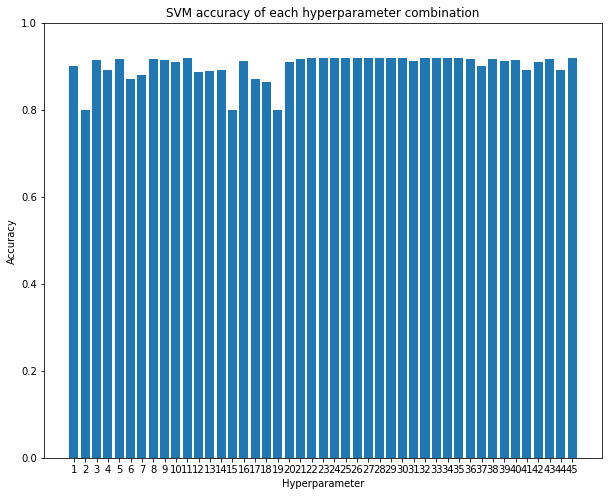

In [17]:
param_accuracies = [0.9018809523809523, 0.8009047619047619, 0.9153809523809524, 0.8922857142857142, 0.9168095238095239, 0.8705, 0.8792619047619047, 0.9178809523809524, 0.9153809523809524, 0.9092619047619047, 0.9204761904761904, 0.8866428571428572, 0.8886666666666667, 0.8926904761904761, 0.8009047619047619, 0.9134285714285716, 0.8705, 0.8652619047619047, 0.8009047619047619, 0.9092619047619047, 0.9178809523809524, 0.919404761904762, 0.919404761904762, 0.919404761904762, 0.9204761904761904, 0.9204761904761904, 0.9204761904761904, 0.9204761904761904, 0.9204761904761904, 0.9200952380952381, 0.9134285714285716, 0.9204761904761904, 0.9204761904761904, 0.9200952380952381, 0.9204761904761904, 0.9168095238095239, 0.9018809523809523, 0.9178809523809524, 0.9134285714285716, 0.9153809523809524, 0.8926904761904761, 0.9092619047619047, 0.9168095238095239, 0.8926904761904761, 0.9200952380952381]

print(param_accuracies)

plot_cv(param_accuracies,'SVM accuracy of each hyperparameter combination','Hyperparameter')

In [7]:
scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=0)
for fold,(train_idx, valid_idx) in enumerate(skf.split(
            reduced_df, labels )):
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print('#'*25)

    X_train = reduced_df.loc[train_idx]
    y_train = labels.loc[train_idx]
    X_valid = reduced_df.loc[valid_idx]
    y_valid = labels.loc[valid_idx]
    svc_opt = SVC(
                            C=9.1, 
                            gamma=0.1, 
                            kernel='rbf'
                        )

    svc_opt.fit(X_train, y_train)
    y_pred = svc_opt.predict(X_valid)
    scores.append(accuracy_score(y_pred, y_valid))
    # svc_opt.save_model(f'SVC_optimal_fold{fold}.sav')
    dump(svc_opt, f'VC_optimal_fold_{fold}.joblib')
    
    del X_train,y_train
    del X_valid, y_valid
print('CV scores: ',scores)


#########################
### Fold 1
### Train size 96000 Valid size 24000
#########################
#########################
### Fold 2
### Train size 96000 Valid size 24000
#########################
#########################
### Fold 3
### Train size 96000 Valid size 24000
#########################
#########################
### Fold 4
### Train size 96000 Valid size 24000
#########################
#########################
### Fold 5
### Train size 96000 Valid size 24000
#########################
CV scores:  [0.8837083333333333, 0.886, 0.882875, 0.8835416666666667, 0.8861666666666667]


NameError: name 'plot_cv' is not defined

CV scores with 5 folds on our reduced dataset:  [0.8837083333333333, 0.886, 0.882875, 0.8835416666666667, 0.8861666666666667]

[1, 2, 3, 4, 5]


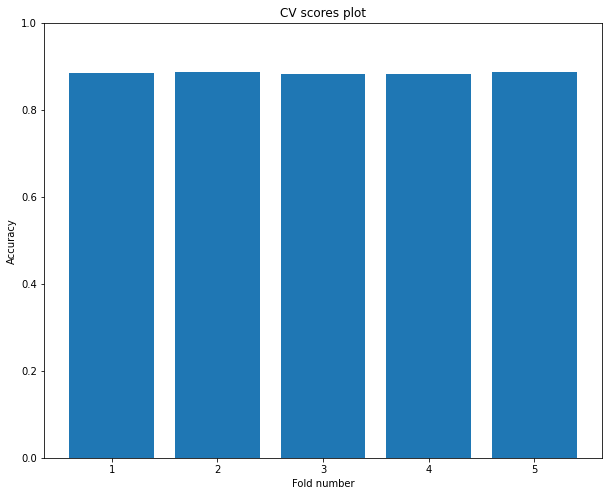

In [9]:
plot_cv(scores)

<h4>We now train our SVM on the whole dataset. And we now want to see, how it performed</h4>

In [11]:
svc_opt = SVC(
                        C=9.1, 
                        gamma=0.1, 
                        kernel='rbf',
                    )
svc_opt.fit(full_df, labels)
y_pred = svc_opt.predict(full_df)
# scores.append(mean_squared_error(labels,y_pred))


print('-- Model Report --')
print('XGBoost Accuracy: '+ str(accuracy_score(y_pred, labels)))
print('XGBoost F1-Score (Micro): '+str(f1_score(y_pred,labels,average='micro')))
print(classification_report(labels, y_pred))

dump(svc_opt, f'SVC_final_model_best_params.joblib')

-- Model Report --
XGBoost Accuracy: 0.9583
XGBoost F1-Score (Micro): 0.9583
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     85358
           1       0.97      0.93      0.95      5833
           2       0.93      0.88      0.90      8954
           3       0.94      0.90      0.92      8198
           4       0.96      0.80      0.87      2324
           5       0.97      0.88      0.92      5111
           6       0.97      0.88      0.92      4222

    accuracy                           0.96    120000
   macro avg       0.96      0.89      0.92    120000
weighted avg       0.96      0.96      0.96    120000



['SVC_final_model_best_params.joblib']

Our trained SVM classifiert performed quite well with accuracy of 95% on test set. 

-- Model Report --
SVC Accuracy: 0.9583
SVC F1-Score (Micro): 0.9583
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     85358
           1       0.97      0.93      0.95      5833
           2       0.93      0.88      0.90      8954
           3       0.94      0.90      0.92      8198
           4       0.96      0.80      0.87      2324
           5       0.97      0.88      0.92      5111
           6       0.97      0.88      0.92      4222

    accuracy                           0.96    120000
   macro avg       0.96      0.89      0.92    120000
weighted avg       0.96      0.96      0.96    120000

In [7]:
svc_opt = SVC(
                        C=7, 
                        gamma='auto', 
                        kernel='rbf',
                        class_weight='balanced'
                    )
svc_opt.fit(reduced_df, labels)
y_pred = svc_opt.predict(reduced_df)
# scores.append(mean_squared_error(labels,y_pred))


print('-- Model Report --')
print('XGBoost Accuracy: '+ str(accuracy_score(y_pred, labels)))
print('XGBoost F1-Score (Micro): '+str(f1_score(y_pred,labels,average='micro')))
print(classification_report(labels, y_pred))

dump(svc_opt, f'SVC_test.joblib')

-- Model Report --
XGBoost Accuracy: 0.8185833333333333
XGBoost F1-Score (Micro): 0.8185833333333333
              precision    recall  f1-score   support

           0       0.97      0.83      0.89     85358
           1       0.60      0.86      0.71      5833
           2       0.70      0.71      0.71      8954
           3       0.70      0.77      0.73      8198
           4       0.37      0.75      0.50      2324
           5       0.50      0.87      0.64      5111
           6       0.51      0.85      0.64      4222

    accuracy                           0.82    120000
   macro avg       0.62      0.81      0.69    120000
weighted avg       0.87      0.82      0.83    120000



['SVC_test.joblib']

<h2>Evaluating test data</h2>

In [8]:
def load_test_set(directory,model,csv_file):
    data = []
    for filename in os.listdir(directory):
        row_name, extension = os.path.splitext(filename)
        f = os.path.join(directory, filename)
        test_data = np.load(f)
        if 'svc' in csv_file:
            print('SCV FILE')
            min_max_scaler = MinMaxScaler()
            full_df_scaled = min_max_scaler.fit_transform(test_data)
            test_data = pd.DataFrame(full_df_scaled, columns=full_df.columns)
            test_data = test_data[top_50_features]
        predictions = model.predict(test_data)
        row = [row_name]+list(predictions)
        data.append(row)
    with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)
    return data

# loaded_xgb = xgb.XGBClassifier()
# loaded_xgb.load_model('XGB_final_model_best_params.xgb')

# load_test_set('test_set',loaded_xgb,'xgb_preds.csv')

# svc_model = load('SVC_final_model_best_params.joblib')
# load_test_set('test_set',svc_model,'svc_preds.csv')



svc_model = load('SVC_test.joblib')
load_test_set('test_set',svc_model,'svc_preds_improve.csv')

SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE
SCV FILE


[['test00',
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  0,
  0,
  1,
  1,
  1,
  3,
  5,
  5,
  5,
  5,
  1,
  5,
  1,
  1,
  5,
  5,
  5,
  1,
  1,
  1,
  3,
  5,
  5,
  5,
  5,
  1,
  5,
  1,
  3,
  5,
  5,
  5,
  1,
  5,
  1,
  3,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5